# German Traffic Signs

<img src="http://forums.fast.ai/uploads/default/original/1X/db56b991503b0d0979af8ea3d59a829970c71a77.png" width="473" height="79">

**Name:** [The German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

**Task:** Image classification

**Training size:** [39,209 images (263 MB)](http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip)

**Test size:** [12,630 images (84 MB)](http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip)

**Number of classes:** 43

**State of the art (2011) [[1](http://benchmark.ini.rub.de/index.php?section=gtsrb&subsection=results)]:** 99.46%

**Human performance: [[2](http://benchmark.ini.rub.de/index.php?section=gtsrb&subsection=results)]** 98.84%

---

**Lesson 1 Vgg16 performance:** 62.15% (12 epochs)

**Lesson 1 Vgg16 validation accuracy:** 81.80% (13 epochs, 20% validation set)

---

vgg16.py: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16.py

utils.py: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py

forums.fast.ai thread: http://forums.fast.ai/t/dataset-discussion-german-traffic-signs/

## Import tools

In [1]:
import os
import csv
import math
from random import shuffle
from glob import glob
from shutil import copyfile
from time import time
import numpy as np
from keras.preprocessing import image
import sklearn

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from vgg16 import Vgg16
import utils

def select_examples(condition, category, expected_labels, predicted_labels, probs, prob_range=(0,1)):
    example_idxs = np.where(condition)[0]
    example_idxs = [idx for idx in example_idxs if prob_range[0] <= max(probs[idx]) <= prob_range[1]]
    print("Found {} {} labels".format(len(example_idxs), category))
    shuffle(example_idxs)
    selected_examples = example_idxs[:12]
    expected = [expected_labels[i] for i in selected_examples]
    predicted = [predicted_labels[i] for i in selected_examples]
    return selected_examples, expected, predicted 

def plots(ims, figsize=(12,6), rows=1, cols=None, interp=False, titles=None):
    # The original function is in utils.py
    # The changes are marked by "# New"
    if not cols: # New
        cols = len(ims)//rows
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        plt.axis('off') # New
        plt.subplots_adjust(hspace = 0.500) # New

def plot_examples(selected_examples, expected_labels, predicted_labels, probs):
    print("Title format: Probability, correct ID, predicted ID")
    print("Plot format: Image, correct sign, predicted sign")
    n = len(selected_examples)
    images = []
    titles = []
    for idx in range(n):
        selected_example = selected_examples[idx]
        expected_label = expected_labels[idx]
        predicted_label = predicted_labels[idx]
        
        img = image.load_img(valid_path+filenames[selected_example])
        true_img = legend_images[expected_label]
        pred_img = legend_images[predicted_label]
        
        prob = max(probs[selected_example])
        true_id = expected_label
        pred_id = predicted_label
        
        images.extend([img, true_img, pred_img])
        titles.extend([prob, true_id, pred_id])
    plots(images, titles=titles, rows=n, cols=12, figsize=(16,16))
        
def mkdirs(dirs):
    for dir_i in dirs:
        try:
            os.makedirs(dir_i)
        except OSError:
            pass
        
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    import itertools # New: Added the import statement
    plt.figure(figsize=(20,20)) # New: Enlarged the figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar() # New: Removed the colorbar
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, tick_marks, rotation=45) # New: Replaced classes (dict) with tick_marks (array)
    plt.yticks(tick_marks, tick_marks) # New: Replaced classes (dict) with tick_marks (array)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def image_of_number(number):
    # build a rectangle in axes coords
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height

    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1], aspect='equal')
    ax.text(0.5*(left+right), 0.5*(bottom+top), number,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=100, color='black',
            transform=ax.transAxes)
    ax.set_axis_off()
    plt.savefig("/tmp/{}.png".format(number), bbox_inches='tight')
    plt.close(fig)

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Prepare the data

### Download the data

In [32]:
outpath = "data/traffic-signs.zip"
if not os.path.isfile(outpath):
    !wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip -O $outpath
else:
    print("File already exists.")

File already exists.


### Unzip the data

In [33]:
!unzip -q data/traffic-signs.zip -d data/

### Convert the images from PPM to PNG

#### Convert the images from PPM to PNG

In [34]:
start = time()
!cd data/GTSRB/Final_Training/Images && mogrify -format png */*.ppm
dur = time() - start
print("Seconds elapsed: {}".format(dur))

Seconds elapsed: 45.9384951591


#### Delete the PPM images

In [35]:
!cd data/GTSRB/Final_Training/Images && find . -name \*.ppm -delete

### Organize the data into the correct folder structure

#### Set up the folder structure

In [36]:
path = "data/traffic-signs/"

In [37]:
rel_dirs = ["train/", "valid/", "sample/train/", "sample/valid/"]

In [38]:
classes = [str(n).zfill(5) for n in range(43)]
classes[:5]

['00000', '00001', '00002', '00003', '00004']

In [39]:
dirs = []
for rel_dir in rel_dirs:
    dirs.extend([path + rel_dir + class_i for class_i in classes])
mkdirs(dirs)
dirs[:5]

['data/traffic-signs/train/00000',
 'data/traffic-signs/train/00001',
 'data/traffic-signs/train/00002',
 'data/traffic-signs/train/00003',
 'data/traffic-signs/train/00004']

#### Split the training data into training and validation sets

##### Get image paths

In [40]:
image_paths = glob("data/GTSRB/Final_Training/Images/*/*.png")
shuffle(image_paths)
len(image_paths)

39209

##### Calculate number of validation images

In [41]:
valid_percent = 0.20
n_images = len(image_paths)
cutoff = int(n_images * valid_percent)
cutoff

7841

##### Split the filenames into train and valid

In [42]:
valid_paths = image_paths[:cutoff]
train_paths = image_paths[cutoff:]
len(valid_paths), len(train_paths), len(image_paths), len(valid_paths) + len(train_paths)

(7841, 31368, 39209, 39209)

##### Ensure the path names make sense

In [43]:
valid_paths[0]

'data/GTSRB/Final_Training/Images/00010/00048_00007.png'

In [44]:
suffix = valid_paths[0].split('Images/')[1]
print(suffix)
print(path + "valid/" + suffix)
print(valid_paths[0])

00010/00048_00007.png
data/traffic-signs/valid/00010/00048_00007.png
data/GTSRB/Final_Training/Images/00010/00048_00007.png


##### Create a sample to test the Vgg code

In [45]:
for valid_path in valid_paths[:20]:
    suffix = valid_path.split('Images/')[1]
    copyfile(valid_path, path + "sample/valid/" + suffix)

In [46]:
for train_path in train_paths[:80]:
    suffix = train_path.split('Images/')[1]
    copyfile(train_path, path + "sample/train/" + suffix)

##### Move the images into train and valid

In [47]:
for valid_path in valid_paths:
    suffix = valid_path.split('Images/')[1]
    os.rename(valid_path, path + "valid/" + suffix)

In [48]:
for train_path in train_paths:
    suffix = train_path.split('Images/')[1]
    os.rename(train_path, path + "train/" + suffix)

## Instantiate the Vgg16 model

In [2]:
vgg = Vgg16()

/opt/conda/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


## Load the data

In [3]:
path = "data/traffic-signs/"
# path = "data/traffic-signs/sample/"
train_path = path + "train/"
valid_path = path + "valid/"
results_path = path + "results/"

In [4]:
batch_size = 64
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


## Finetune the Vgg16 model for this data

In [5]:
vgg.finetune(batches)

## Fit the Vgg16 model to this data

In [53]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
31368/31368 [==============================] - 403s - loss: 2.1723 - acc: 0.4334 - val_loss: 1.0928 - val_acc: 0.6614


### Save the model

In [55]:
epoch = 1
latest_weights_filename = results_path + 'ft%d.h5' % epoch
mkdirs([results_path])
vgg.model.save_weights(latest_weights_filename)
print("Saved model to: " + latest_weights_filename)

Saved model to: data/traffic-signs/results/ft1.h5


### Fit some more

In [57]:
for epoch in range(2, 4):
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = results_path + 'ft%d.h5' % epoch
    vgg.model.save_weights(latest_weights_filename)
    print("Saved model to: " + latest_weights_filename)

Epoch 1/1
31368/31368 [==============================] - 401s - loss: 1.5112 - acc: 0.5720 - val_loss: 0.9033 - val_acc: 0.7179
Saved model to: data/traffic-signs/sample/results/ft2.h5
Epoch 1/1
31368/31368 [==============================] - 401s - loss: 1.3957 - acc: 0.6020 - val_loss: 0.7892 - val_acc: 0.7449
Saved model to: data/traffic-signs/sample/results/ft3.h5


In [6]:
vgg.model.load_weights(results_path+'ft%d.h5' % 3)
vgg.fit(batches, val_batches, nb_epoch=1)
latest_weights_filename = results_path + 'ft%d.h5' % 4
vgg.model.save_weights(latest_weights_filename)

Epoch 1/1
31368/31368 [==============================] - 406s - loss: 1.3828 - acc: 0.6127 - val_loss: 0.7382 - val_acc: 0.7634


### And some more

In [6]:
vgg.model.load_weights(results_path+'ft%d.h5' % 4)

In [7]:
for epoch in range(5, 11):
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = results_path + 'ft%d.h5' % epoch
    vgg.model.save_weights(latest_weights_filename)
    print("Saved model to: " + latest_weights_filename)

Epoch 1/1
31368/31368 [==============================] - 399s - loss: 1.3639 - acc: 0.6273 - val_loss: 0.7206 - val_acc: 0.7643
Saved model to: data/traffic-signs/results/ft5.h5
Epoch 1/1
31368/31368 [==============================] - 408s - loss: 1.3290 - acc: 0.6334 - val_loss: 0.6283 - val_acc: 0.7966
Saved model to: data/traffic-signs/results/ft6.h5
Epoch 1/1
31368/31368 [==============================] - 400s - loss: 1.3054 - acc: 0.6435 - val_loss: 0.6115 - val_acc: 0.8019
Saved model to: data/traffic-signs/results/ft7.h5
Epoch 1/1
31368/31368 [==============================] - 399s - loss: 1.2843 - acc: 0.6512 - val_loss: 0.6348 - val_acc: 0.7921
Saved model to: data/traffic-signs/results/ft8.h5
Epoch 1/1
31368/31368 [==============================] - 402s - loss: 1.3105 - acc: 0.6456 - val_loss: 0.6627 - val_acc: 0.7855
Saved model to: data/traffic-signs/results/ft9.h5
Epoch 1/1
31368/31368 [==============================] - 401s - loss: 1.3031 - acc: 0.6537 - val_loss: 0.5719 

In [8]:
vgg.model.load_weights(results_path+'ft%d.h5' % 10)
for epoch in range(11, 15):
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = results_path + 'ft%d.h5' % epoch
    vgg.model.save_weights(latest_weights_filename)
    print("Saved model to: " + latest_weights_filename)

Epoch 1/1
31368/31368 [==============================] - 398s - loss: 1.2699 - acc: 0.6623 - val_loss: 0.5888 - val_acc: 0.8049
Saved model to: data/traffic-signs/results/ft11.h5
Epoch 1/1
31368/31368 [==============================] - 404s - loss: 1.3019 - acc: 0.6565 - val_loss: 0.5757 - val_acc: 0.8118
Saved model to: data/traffic-signs/results/ft12.h5
Epoch 1/1
31368/31368 [==============================] - 402s - loss: 1.2896 - acc: 0.6624 - val_loss: 0.5580 - val_acc: 0.8180
Saved model to: data/traffic-signs/results/ft13.h5
Epoch 1/1
31368/31368 [==============================] - 400s - loss: 1.2808 - acc: 0.6641 - val_loss: 0.5938 - val_acc: 0.8056
Saved model to: data/traffic-signs/results/ft14.h5


## Predict labels

In [5]:
path = "data/traffic-signs/"
# path = "data/traffic-signs/sample/"
valid_path = path + "valid/"
results_path = path + "results/"
vgg = Vgg16()
vgg.model.load_weights(results_path+'ft%d.h5' % 3)

/opt/conda/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [7]:
start = time()
batch_size = 64
val_batches, probs = vgg.test(valid_path, batch_size=batch_size*2)
print("{:.0f} seconds elapsed".format(time() - start))

Found 7841 images belonging to 43 classes.
84 seconds elapsed


## Show legend

In [69]:
!mkdir data/traffic-signs/legend

mkdir: cannot create directory 'data/traffic-signs/legend': File exists


In [8]:
legend_path = path + "legend/"
n_classes = 43
legend_images = []
for i in range(n_classes):
    class_i = str(i).zfill(5)
    filename = "{}.jpg".format(class_i)
    url = "http://benchmark.ini.rub.de/Images/signs/" + filename
    if not os.path.isfile(legend_path+filename):
        !cd $legend_path && wget -q $url
    img = image.load_img(legend_path+class_i+".jpg")
    legend_images.append(img)

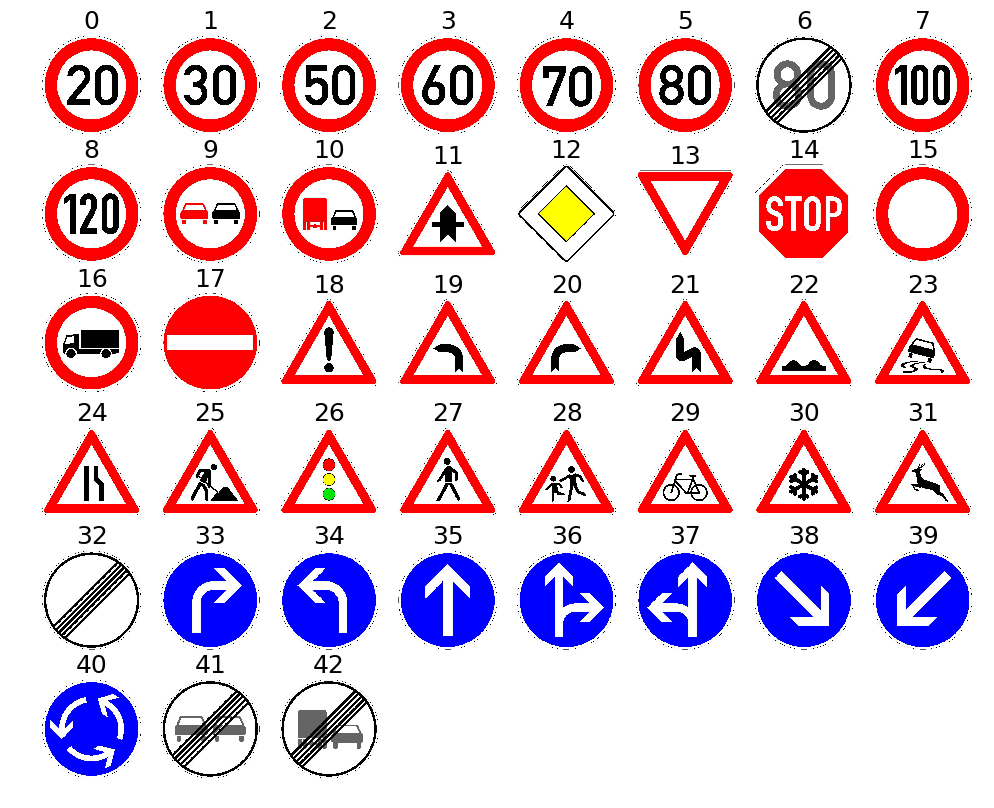

In [78]:
plots(legend_images, titles=range(n_classes), rows=11, cols=8, figsize=(12,18))

## Show an example from each class

In [79]:
filenames = val_batches.filenames

In [80]:
images = []
n_classes = 43
for class_i in range(n_classes):
    # Find an example of that class
    for idx in range(len(filenames)):
        if val_batches.classes[idx] == class_i:
            img = image.load_img(valid_path+filenames[idx])
            images.append(img)
            break

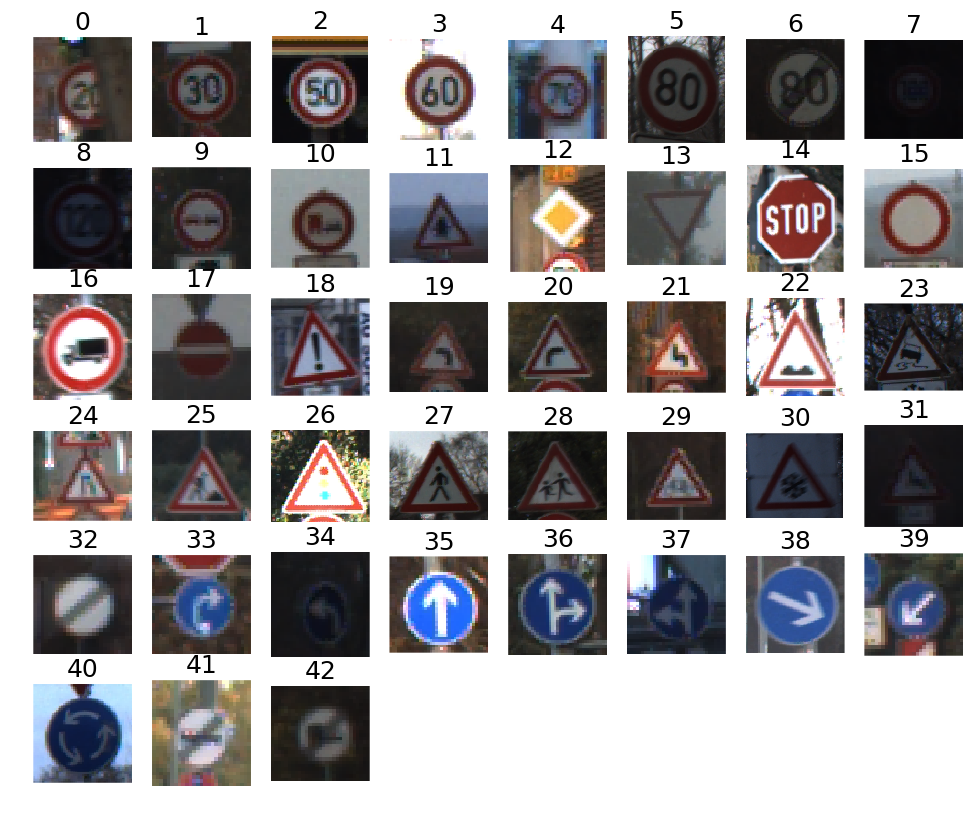

In [81]:
plots(images, titles=range(n_classes), rows=11, cols=8, figsize=(12,18))

## Inspect predictions

In [82]:
expected_labels = val_batches.classes
predicted_labels = [np.argmax(probs_i) for probs_i in probs]

### Correct

Found 5841 correct labels
Title format: Probability, correct ID, predicted ID
Plot format: Image, correct sign, predicted sign


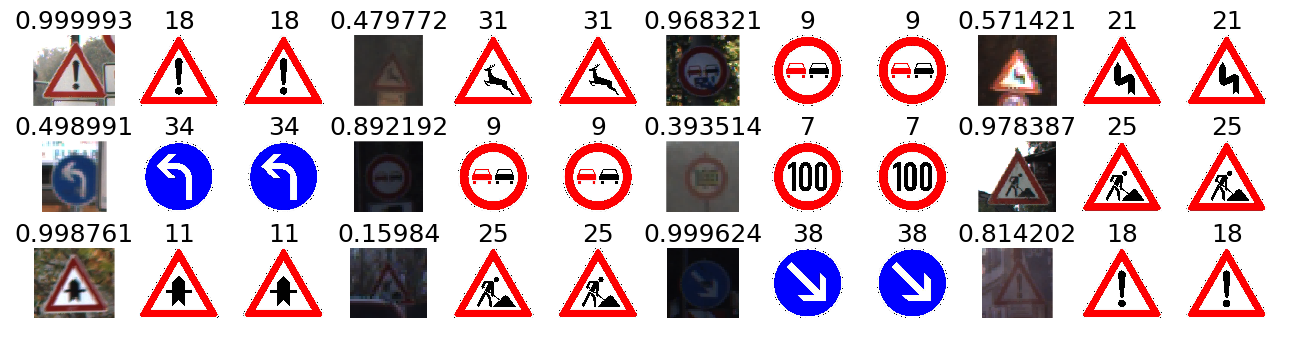

In [114]:
condition = expected_labels==predicted_labels
category = "correct"
selected_examples, expected, predicted = select_examples(condition, category,
                                                         expected_labels, predicted_labels, probs)
plot_examples(selected_examples, expected, predicted, probs)

### Incorrect

Found 2000 incorrect labels
Title format: Probability, correct ID, predicted ID
Plot format: Image, correct sign, predicted sign


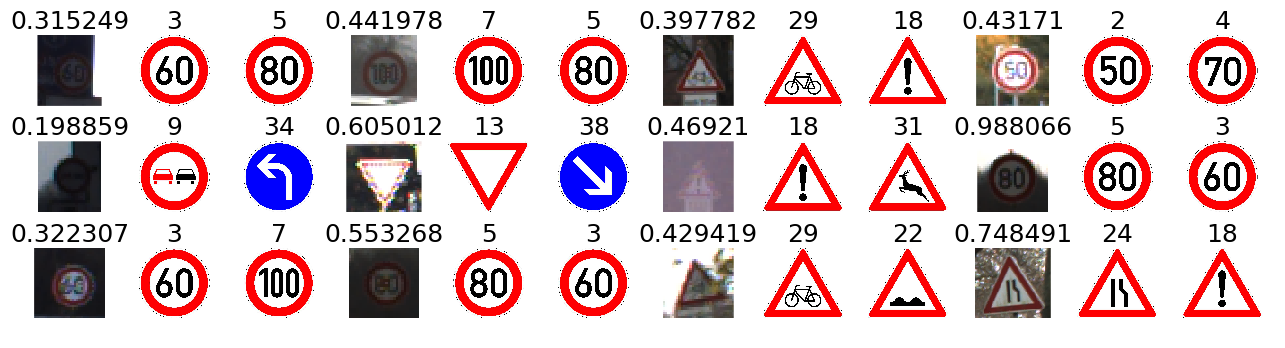

In [118]:
condition = expected_labels!=predicted_labels
category = "incorrect"
selected_examples, expected, predicted = select_examples(condition, category,
                                                         expected_labels, predicted_labels, probs)
plot_examples(selected_examples, expected, predicted, probs)

### Very correct

Probability range: 0.95 to 1.00
Found 2733 very correct labels
Title format: Probability, correct ID, predicted ID
Plot format: Image, correct sign, predicted sign


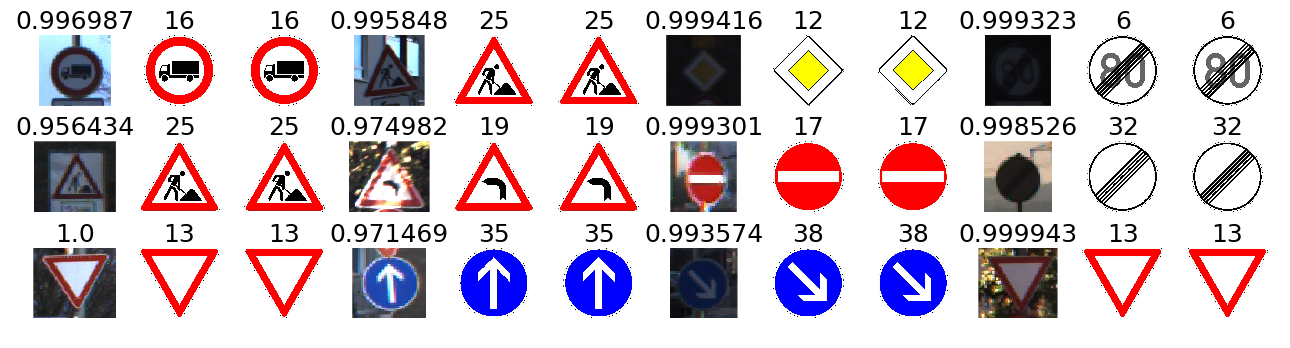

In [128]:
condition = expected_labels==predicted_labels
prob_range = (0.95, 1)
print "Probability range: {:.2f} to {:.2f}".format(*prob_range)
category = "very correct"
selected_examples, expected, predicted = select_examples(condition, category,
                                                         expected_labels, predicted_labels,
                                                         probs, prob_range=prob_range)
plot_examples(selected_examples, expected, predicted, probs)

### Very incorrect

Probability range: 0.95 to 1.00
Found 29 very incorrect labels
Title format: Probability, correct ID, predicted ID
Plot format: Image, correct sign, predicted sign


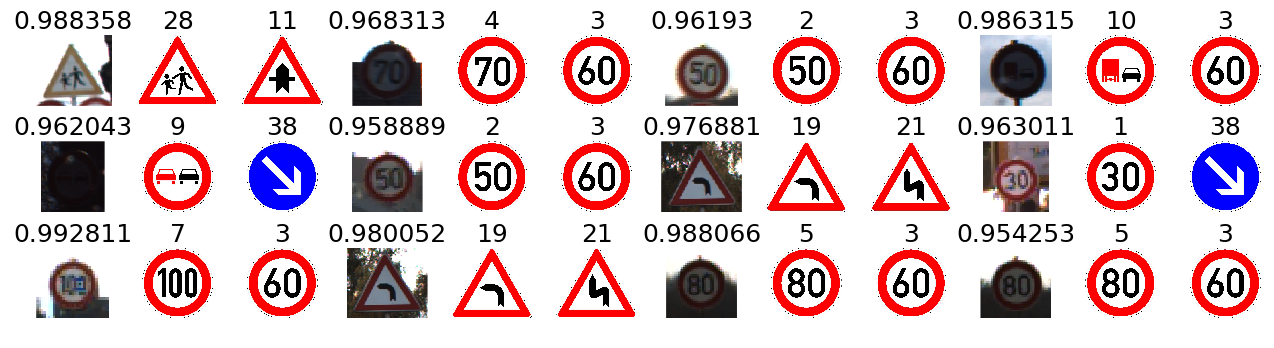

In [130]:
condition = expected_labels!=predicted_labels
prob_range = (0.95, 1)
print "Probability range: {:.2f} to {:.2f}".format(*prob_range)
category = "very incorrect"
selected_examples, expected, predicted = select_examples(condition, category,
                                                         expected_labels, predicted_labels,
                                                         probs, prob_range=prob_range)
plot_examples(selected_examples, expected, predicted, probs)

### Unsure

Chance probability: 0.02
Probability range: 0.00 to 0.14
Found 19 unsure labels
Title format: Probability, correct ID, predicted ID
Plot format: Image, correct sign, predicted sign


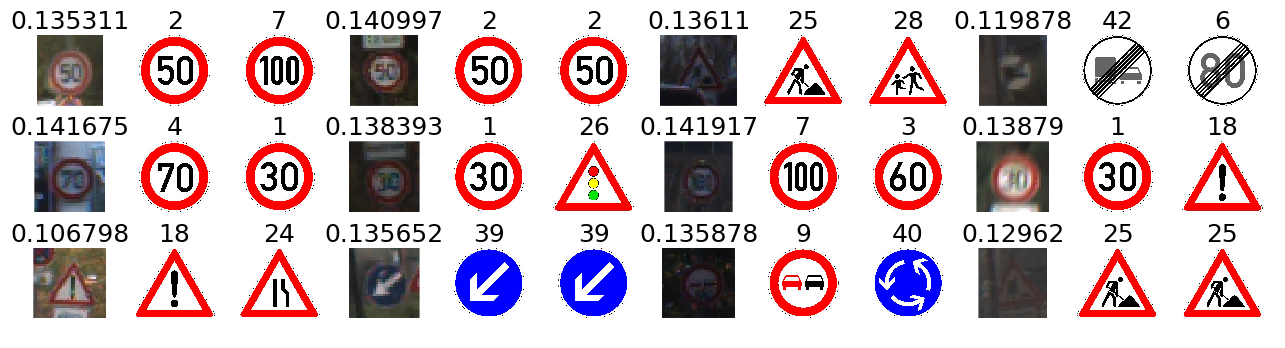

In [127]:
condition = expected_labels==expected_labels
chance = 1/43.
print "Chance probability: {:.2f}".format(chance)
epsilon = 0.12
low = max(0, chance-epsilon)
high = min(1, chance+epsilon)
prob_range = (low, high)
print "Probability range: {:.2f} to {:.2f}".format(*prob_range)
category = "unsure"
selected_examples, expected, predicted = select_examples(condition, category,
                                                         expected_labels, predicted_labels,
                                                         probs, prob_range=prob_range)
plot_examples(selected_examples, expected, predicted, probs)

## Confusion matrix

[[ 28   2   0 ...,   0   0   0]
 [  7 305  14 ...,   0   0   0]
 [  6  48 190 ...,   0   1   0]
 ..., 
 [  0   0   0 ...,  44   0   0]
 [  0   0   0 ...,   0  50   0]
 [  0   0   0 ...,   0   9  34]]


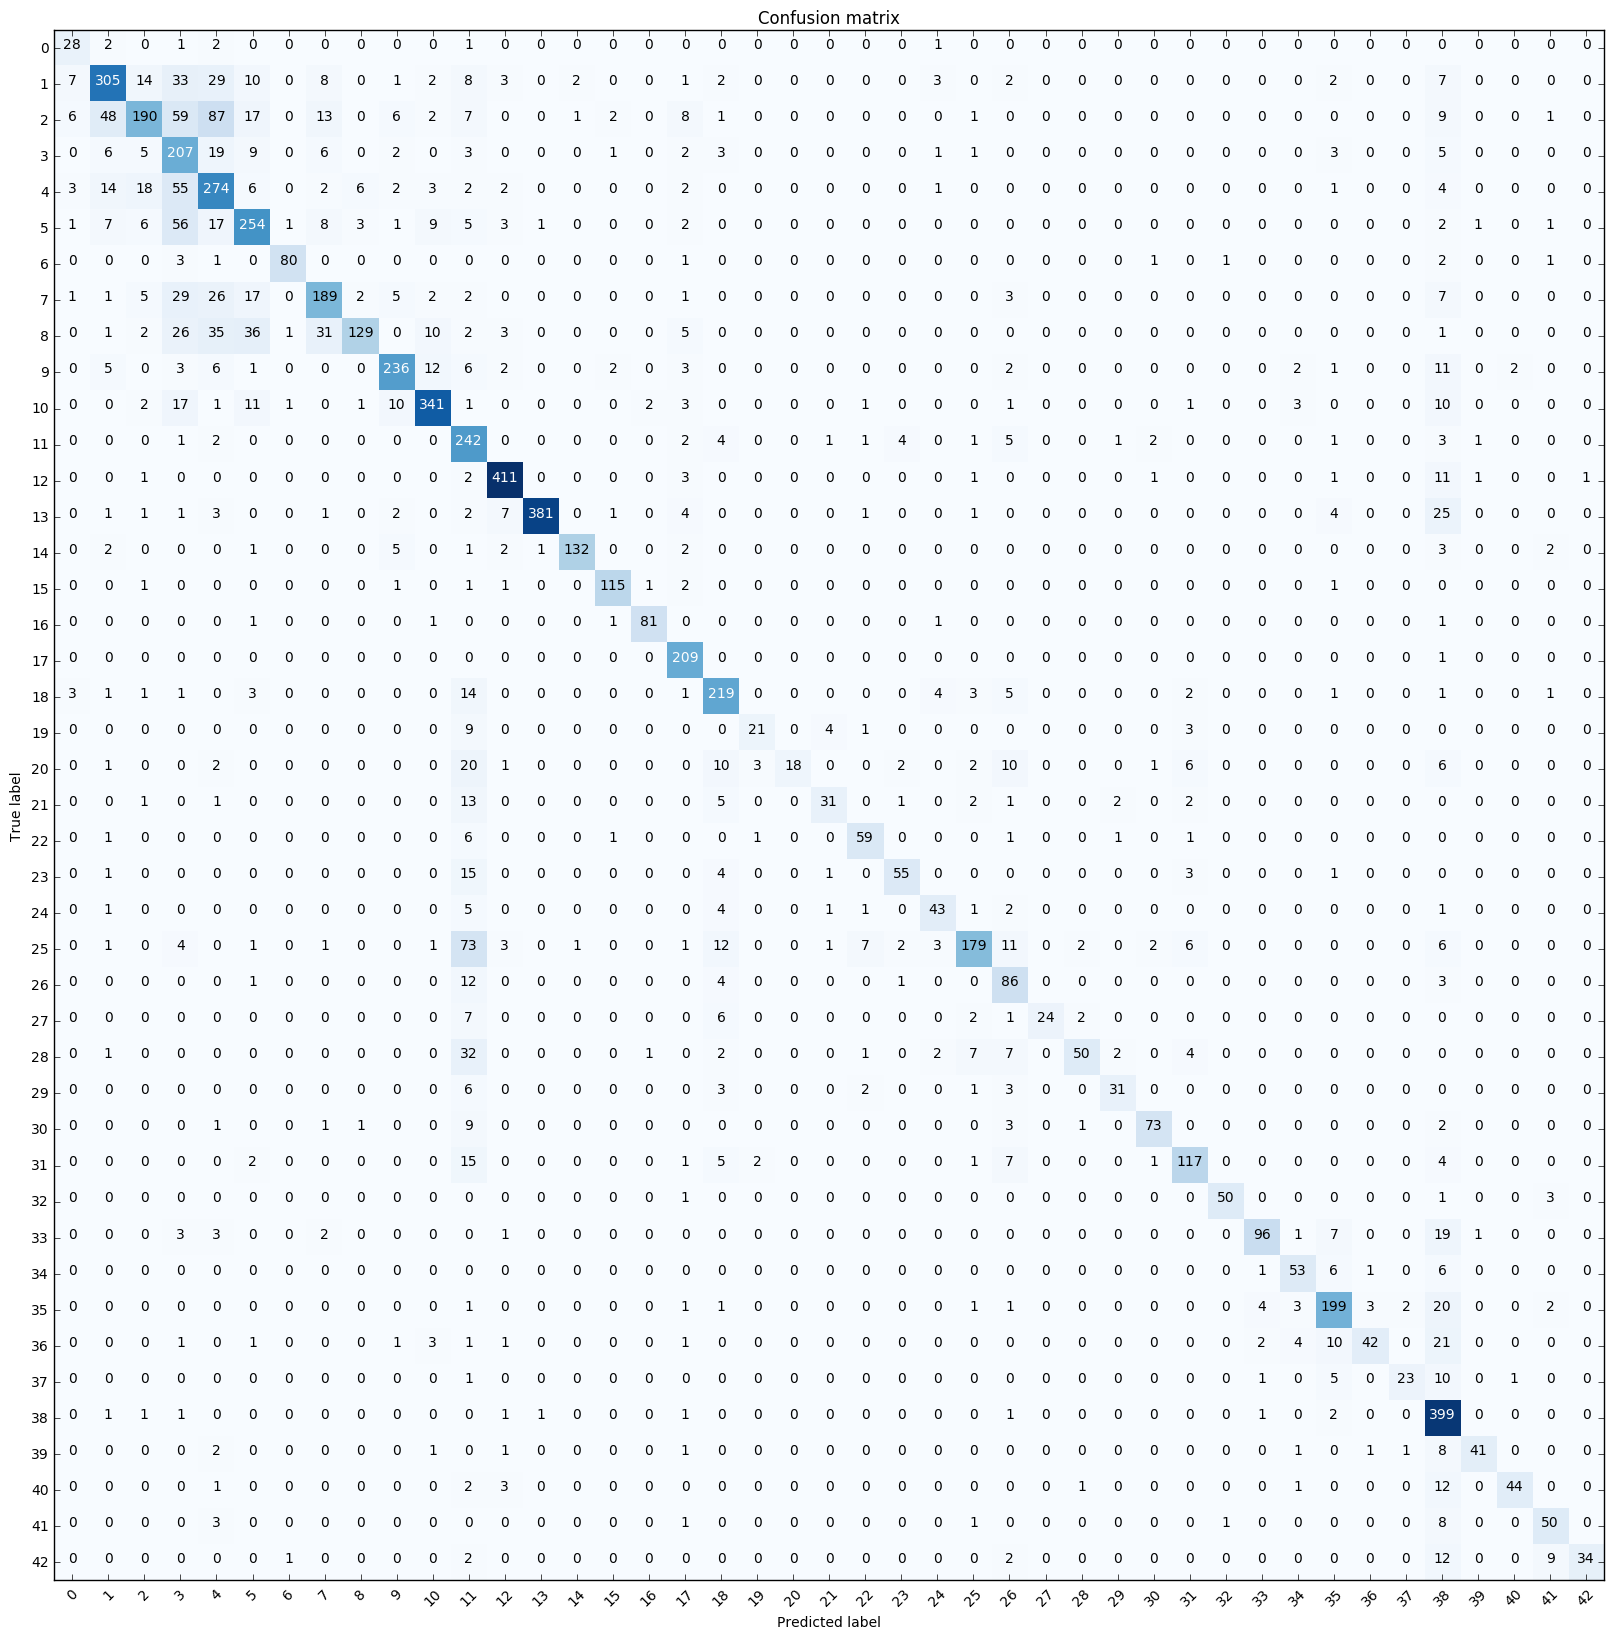

In [114]:
expected_labels = val_batches.classes
predicted_labels = [np.argmax(probs_i) for probs_i in probs]

cm = sklearn.metrics.confusion_matrix(expected_labels, predicted_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [106]:
# Find the pairs that correspond to 10 or more confusions
n_classes = 43
confusion_threshold = 10
confusions = []
for true_id in range(n_classes):
    for pred_id in range(n_classes):
        n_confusions = cm[true_id][pred_id]
        if n_confusions >= confusion_threshold and true_id != pred_id:
            confusions.append((true_id, pred_id, n_confusions))
confusions = sorted(confusions, key=lambda x:x[2], reverse=True)

Plot format: True sign, predicted sign, number of confusions


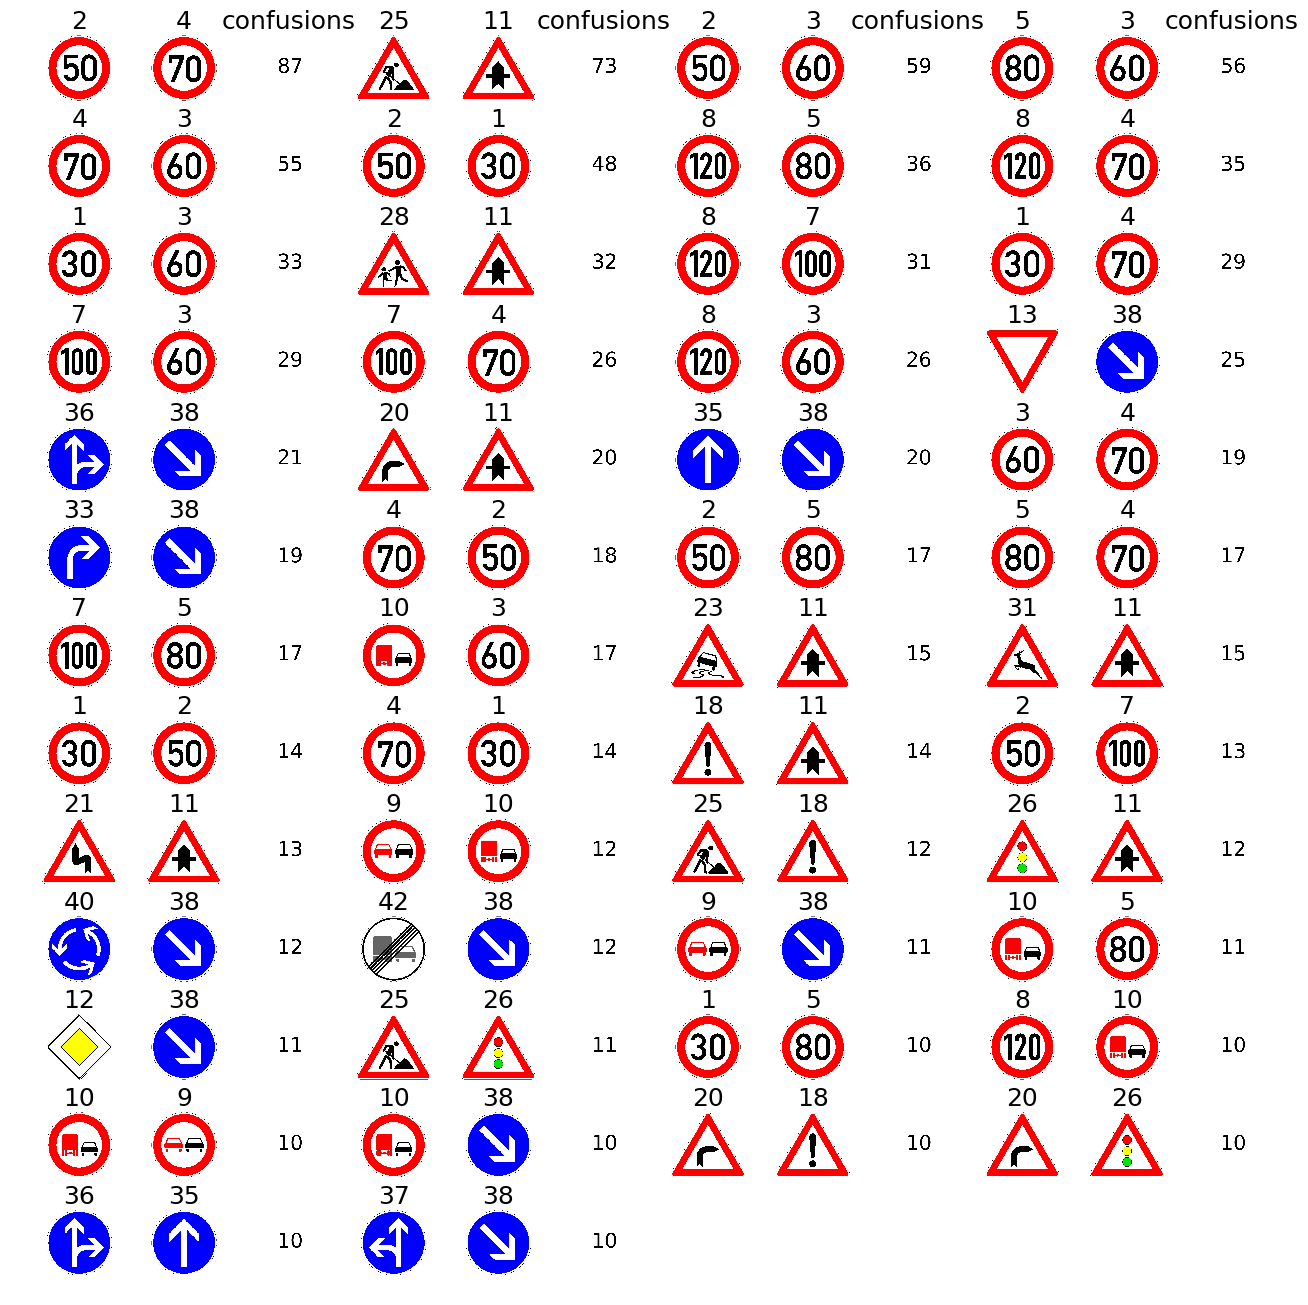

In [110]:
images = []
titles = []
count = 0
for true_id, pred_id, n_confusions  in confusions:
    true_img = legend_images[true_id]
    pred_img = legend_images[pred_id]
    image_of_number(n_confusions)
    number_img = image.load_img("/tmp/{}.png".format(n_confusions))
    images.extend([true_img, pred_img, number_img])
    if count < 4:
        title = "confusions"
    else:
        title = ""
    titles.extend([true_id, pred_id, title])
    count += 1     
rows = int(math.ceil(len(confusions) / 4.))
print("Plot format: True sign, predicted sign, number of confusions")
plots(images, titles=titles, rows=rows, cols=12, figsize=(16,16))

## Test the model

### Train on all the data

In [25]:
!unzip -q data/traffic-signs.zip -d data/

In [26]:
!cd data/GTSRB/Final_Training/Images && mogrify -format png */*.ppm

In [27]:
!cd data/GTSRB/Final_Training/Images && find . -name \*.ppm -delete

In [28]:
path = "data/traffic-signs/"
classes = [str(n).zfill(5) for n in range(43)]
train_all_path = path + "train_all/"
dirs = [train_all_path + class_i for class_i in classes]
mkdirs(dirs)
image_paths = glob("data/GTSRB/Final_Training/Images/*/*.png")
for image_path in image_paths:
    suffix = image_path.split('Images/')[1]
    os.rename(image_path, train_all_path + suffix)

In [30]:
vgg = Vgg16()
batch_size = 64
batches = vgg.get_batches(train_all_path, batch_size=batch_size)
val_batches = vgg.get_batches(path+"valid/", batch_size=batch_size*2)
vgg.finetune(batches)
n_epochs = 4
for epoch_i in range(n_epochs):
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = results_path + 'all_ft%d.h5' % epoch_i
    vgg.model.save_weights(latest_weights_filename)
    print("Saved model to: " + latest_weights_filename)

/opt/conda/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_6 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Found 39209 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Epoch 1/1
39209/39209 [==============================] - 477s - loss: 2.0728 - acc: 0.4530 - val_loss: 0.9381 - val_acc: 0.7085
Saved model to: data/traffic-signs/results/all_ft0.h5
Epoch 1/1
39209/39209 [==============================] - 483s - loss: 1.4665 - acc: 0.5815 - val_loss: 0.8231 - val_acc: 0.7440
Saved model to: data/traffic-signs/results/all_ft1.h5
Epoch 1/1
39209/39209 [==============================] - 483s - loss: 1.3921 - acc: 0.6063 - val_loss: 0.6463 - val_acc: 0.8007
Saved model to: data/traffic-signs/results/all_ft2.h5
Epoch 1/1
39209/39209 [==============================] - 488s - loss: 1.3399 - acc: 0.6241 - val_loss: 0.6069 - val_acc: 0.8017
Saved model to: data/traffic-signs/results/all_ft3.h5


#### More training

In [5]:
path = "data/traffic-signs/"
train_all_path = path + "train_all/"
results_path = path + "results/"
vgg = Vgg16()
batch_size = 64
batches = vgg.get_batches(train_all_path, batch_size=batch_size)
val_batches = vgg.get_batches(path+"valid/", batch_size=batch_size*2)
vgg.finetune(batches)
vgg.model.load_weights(results_path+'all_ft%d.h5' % 3)
for epoch_i in range(4, 16):
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = results_path + 'all_ft%d.h5' % epoch_i
    vgg.model.save_weights(latest_weights_filename)
    print("Saved model to: " + latest_weights_filename)

/opt/conda/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Found 39209 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Epoch 1/1
39209/39209 [==============================] - 482s - loss: 1.3527 - acc: 0.6254 - val_loss: 0.5519 - val_acc: 0.8163
Saved model to: data/traffic-signs/results/all_ft4.h5
Epoch 1/1
39209/39209 [==============================] - 482s - loss: 1.3084 - acc: 0.6415 - val_loss: 0.5028 - val_acc: 0.8365
Saved model to: data/traffic-signs/results/all_ft5.h5
Epoch 1/1
39209/39209 [==============================] - 485s - loss: 1.3239 - acc: 0.6438 - val_loss: 0.4821 - val_acc: 0.8396
Saved model to: data/traffic-signs/results/all_ft6.h5
Epoch 1/1
39209/39209 [==============================] - 483s - loss: 1.3091 - acc: 0.6479 - val_loss: 0.4808 - val_acc: 0.8382
Saved model to: data/traffic-signs/results/all_ft7.h5
Epoch 1/1
39209/39209 [==============================] - 480s - loss: 1.3147 - acc: 0.6509 - val_loss: 0.5032 - val_acc: 0.8244
Saved model to: data/traffic-signs/results/all_ft8.h5
Epo

### Download the test images

In [3]:
outpath = "data/traffic-signs-test.zip"
if not os.path.isfile(outpath):
    !wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip -O $outpath
else:
    print("File already exists.")

File already exists.


In [4]:
!unzip -q data/traffic-signs-test.zip -d data/

### Convert the images from PPM to PNG

In [5]:
start = time()
!cd data/GTSRB/Final_Test/Images && mogrify -format png *.ppm
print("{:.0f} seconds elapsed".format(time() - start))

13 seconds elapsed


In [6]:
!cd data/GTSRB/Final_Test/Images && find . -name \*.ppm -delete

### Organize the images into the correct folder structure

In [6]:
image_paths = "data/GTSRB/Final_Test/Images/*.png"
test_path = "data/traffic-signs/test/"
unknown_path = test_path + "unknown"
!mkdir -p $unknown_path
!mv $image_paths $unknown_path

mv: cannot stat 'data/GTSRB/Final_Test/Images/*.png': No such file or directory


### Load the model

In [10]:
vgg = Vgg16()
path = "data/traffic-signs/"
results_path = path + "results/"
vgg.model.load_weights(results_path+'all_ft%d.h5' % 12)

/opt/conda/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


### Predict the labels

In [11]:
batch_size = 64
start = time()
test_batches, probs = vgg.test(test_path, batch_size=batch_size*2)
print("{:.0f} seconds elapsed".format(time() - start))

Found 12630 images belonging to 1 classes.
133 seconds elapsed


### Prepare the CSV

In [12]:
filenames = test_batches.filenames
ids = [filename.split('/')[1].split('.')[0] + ".ppm" for filename in filenames]
classes = [np.argmax(prob) for prob in probs]
pairs = zip(ids, classes)
with open(results_path+"submission--lesson-1--vgg16--12-epochs--peak.csv", "w") as f:
    writer = csv.writer(f, delimiter=";")
    writer.writerows(pairs)